<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S7_YOLOv3_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Notebook Title](http://blog.ibanyez.info/download/B20190408T000000071.jpg)

# How to train YOLOv3 using Darknet on Colab notebook and optimize the VM runtime load times

## Welcome!

This Colab notebook will show you how to:

* Train a **Yolo v3** model using **Darknet** using the Colab **12GB-RAM GPU**.
* Turn Colab notebooks into an effective tool to work on real projects. Dealing with the handicap of a runtime that will **blow up every 12 hours** into the space!
  * Working directly from the files on your computer.
  * Configure your notebook to install everything you need and start training in about a minute (Tested using 550MB dataset). 
  * Receive your trained weights directly on your computer during the training. While the notebook is training you can check how it is going using your trained weights in your computer.


#### This notebook is part of the post [How to train YOLOv3 using Darknet framework and optimize the VM runtime load times](http://blog.ibanyez.info/blogs/coding/20190410-run-a-google-colab-notebook-to-train-yolov3-using-darknet-in/) I encourage you to visit! You will find a deeper explanation about Google Colab, the goods and the limitations of this great tool. 


### These are the steps we'll follow:

* Configure Google Drive and map as network  _Drive_.
* Some utils to help to do some tasks.
* Configure the pre-requisites on the runtime.
  * Check the CUDA installation on the runtime VM.
  * Install cuDNN.
  * Clone and compile Darknet. We'll use a repo based on [AlexeyAB's Darknet repo](https://github.com/AlexeyAB/darknet/). I applied  some changes to make possible to load files from `/My Drive/` and reduced the number of logs on console to speed up the notebook.
  * We'll check that everything works great.
* Explained how to manage your YOLO files on your computer and it will be used transparently from this notebook.

> _**NOTE:** Cells with an annotation **`# Not Necessary cell`**. Can be removed without having any impact. They are only explanatory content._

### Without further ado, let's start!


## STEP 0. Configure runtime to work with GPU

We want to use the **12GB-RAM GPU** hardware acceleration!

Go to **> Menu > Runtime > Configure Runtime Type** And select **GPU** From the **Hardware accelerator** drop down meu

## STEP 1. Connect your files to Google Drive
In order to have your files in your local computer you need to install and configure Google Backup and Sync to keep one folder of your Drive synced with a folder on your computer.

![schema drive.jpg](http://blog.ibanyez.info/download/B20190408T000000060.jpg)

1. Create a folder on your Google Drive named _**darknet**_
2. Configure the Google Backup and Sync as follows. If you don't speak Spanish, you maybe learn some words! **;)**
![Sync Drive.jpg](http://blog.ibanyez.info/download/B20190408T000000063.jpg)

**After this step you'll have a folder called _darknet_ in your local computer. This folder is where you will work with files on your computer**

> _**TIP** - We need to have a good performance downloading data from Drive to Colab. Having a lot of files in your Drive root folder can slow down the things quite a bit. It's a good practice working with Colab to move all your root folder files into a folder_




## STEP 2. Connect the Colab notebook to Google Drive

Now we're gonna map your Google Drive folder. This first step is the only one that will require your manual interaction every time you run your notebook.

* Execute the following cell _(Click on Play button or press CTRL + ENTER)_ and click on the link to authorize your notebook to access to your Google Drive. 
* Paste the code Google will give to you and push `enter`

In [18]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files 
# using this path "/content/drive/My Drive/"

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Congratulations! Now you can access to your local computer folder directly from here!

Check it out!

In [2]:
# Not Necessary cell
# List the content of your local computer folder 
!ls -la "/content/drive/My Drive/darknet"

total 30
drwx------ 2 root root 4096 Oct 23 12:37 backup
drwx------ 2 root root 4096 Oct 22 14:56 bin
drwx------ 2 root root 4096 Oct 23 12:38 cfg
drwx------ 2 root root 4096 Oct 22 14:52 cuDNN
drwx------ 2 root root 4096 Oct 23 08:18 img
-rw------- 1 root root  217 Oct 23 13:30 obj.data
-rw------- 1 root root    5 Oct 23 14:33 obj.names
-rw------- 1 root root  150 Oct 23 14:32 test.txt
drwx------ 2 root root 4096 Oct 23 18:52 tmp
-rw------- 1 root root  351 Oct 23 14:32 train.txt
drwx------ 2 root root 4096 Oct 23 12:38 weights


In [0]:
!sudo apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 28 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (96.2 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package tree.
(Reading database ... 132681 files and directories currently instal

In [0]:
!tree /content/drive/My\ Drive/darknet/

/content/drive/My Drive/darknet/
├── bin
│   └── darknet
└── cuDNN
    └── cudnn-10.0-linux-x64-v7.5.0.56.tgz

3 directories, 1 file


### UPDATE NOTE

If you want to simplify your paths, you can use a Symbolic link:

`!ln -s "/content/drive/My Drive/darknet/" /mydrive`

 Then you'll be able to access your Google Drive files just using `/mydrive` path

**BE CAREFUL: All the paths in this notebook are without using Symbolic link. You'll have to remember to change the path everywhere**

Thanks to **Dennis Kashkin** for this recommendation!

In [0]:
# Uncomment if you want to use Symbolic link
#!ln -s /content/drive/My\ Drive/darknet/ /mydrive
#!ls /mydrive

## STEP 2. Check CUDA release version

Nvidia CUDA is pre-installed on Colab notebooks. Now we'll check the version installed.

> _**BE AWARE:** Maybe some time from the time I'm writing these lines (April 9th, 2019)  the CUDA version is upgraded on Colab and you should download another version of the cuDNN in the next step. Now is release 10.0 and we are using cuDNN (cudnn-10.0-linux-x64-v7.5.0.56.tgz) accordingly_

In [0]:
# This cell can be commented once you checked the current CUDA version
# CUDA: Let's check that Nvidia CUDA is already pre-installed and which version is it. In some time from now maybe you 
!/usr/local/cuda/bin/nvcc --version


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


## STEP 3. Install cuDNN according to the current CUDA version
Now, you need to download cuDNN from Nvidia web site. You'll need to sign up on the site.

* Download cuDNN from [Nvidia website](https://developer.nvidia.com/cudnn) 

  * Right now, because we have _**CUDA 10.0**_ preinstalled in Colab runtime, you need download [cuDNN v7.5.0.56 for CUDA v10.0](https://developer.nvidia.com/compute/machine-learning/cudnn/secure/v7.5.0.56/prod/10.0_20190219/cudnn-10.0-linux-x64-v7.5.0.56.tgz) - the file is cudnn-10.0-linux-x64-v7.5.0.56.tgz

* On your local computer, create a folder named _**cuDNN**_ in your local folder _**darknet**_. Copy the _**tgz**_ file there 



In [3]:
# We're unzipping the cuDNN files from your Drive folder directly to the VM CUDA folders
!tar -xzvf /content/drive/My\ Drive/darknet/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# Now we check the version we already installed. Can comment this line on future runs
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


## STEP 4. Installing Darknet
Great!! We have all the necessary to start working with Darknet. 

This notebook works with a slightly modified version of darknet, which is based on the [AlexeyAB Darknet repo](https://github.com/AlexeyAB/darknet/)
The changes applied to the original repo are:
* Allowing to use spaces on the darknet configuration files _**obj.data**_. Necessary to work with Google Drive directly.
* Removing some logs on every epoch. The original repo write more logs than the Colab notebook can sync. This creates a long queue during the training. This version only shows the results after every iteration.

You can take a look to the code at the [github repo](https://github.com/kriyeng/darknet/)

> _**TRICK**: Because we want to run the notebook fast every time we will compile darknet only the first time we run this notebook. Then, we'll save the compiled version to your drive. For the future executions we'll copy the compiled one instead of compiling again._ 


**Here comes our first trick to speed up the runtime load time**

* The first time we will:
  * Clone and compile the darknet project.
  * Copy the compiled version to our Google Drive Floder
  
* The next times, instead of compiling it again on every runtime load, we'll copy the compiled version to our VM machine!

When compiling the first time, your output last line has to be something like this:

`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU (...)`

## STEP 4-A. Cloning and compiling Darkent. ONLY NEEDS TO BE RUN ON THE FIRST EXECUTION!!
In this step we'll clone the darkent repo and compile it. 
* Clone Repo
* Compile Darknet
* Copy compiled version to Drive

When compiling ends, your output last line has to be something like this:

_`g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU (...)_`

In [4]:
# Leave this code uncommented on the very first run of your notebook or if you ever need to recompile darknet again.
# Comment this code on the future runs.
!git clone https://github.com/kriyeng/darknet/
%cd darknet

# Check the folder
!ls

# I have a branch where I have done the changes commented above
!git checkout feature/google-colab

#Compile Darknet
!make

#Copies the Darknet compiled version to Google drive
#!cp ./darknet /content/drive/My\ Drive/darknet/bin/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 10068, done.
remote: Total 10068 (delta 0), reused 0 (delta 0), pack-reused 10068
Receiving objects: 100% (10068/10068), 9.98 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (6763/6763), done.
/content/darknet
3rdparty      CMakeLists.txt	      image_yolov3.sh	     scripts
appveyor.yml  CMakeSettings.json      include		     src
build	      DarknetConfig.cmake.in  json_mjpeg_streams.sh  video_v2.sh
build.ps1     darknet.py	      LICENSE		     video_yolov3.sh
build.sh      darknet_video.py	      Makefile
cfg	      data		      net_cam_v3.sh
cmake	      image_yolov2.sh	      README.md
Branch 'feature/google-colab' set up to track remote branch 'feature/google-colab' from 'origin'.
Switched to a new branch 'feature/google-colab'
mkdir -p obj
mkdir -p backup
mkdir -p results
chmod +x *.sh
g++ -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wn

## STEP 4-B. Copying the compiled version of Darknet from Drive. UNCOMMENT AFTER FIRST EXECUTION
Copy the darknet compiled version from drive to the VM.
* Make the local darknet folder
* Copy the darknet file
* Set execution permissions

In [0]:
# Uncomment after the first run, when you have a copy of compiled darkent in your Google Drive

# Makes a dir for darknet and move there
#!mkdir darknet
#%cd darknet

# Copy the Darkent compiled version to the VM local drive
#!cp /content/drive/My\ Drive/darknet/bin/darknet ./darknet

# Set execution permissions to Darknet
#!chmod +x ./darknet


[Errno 2] No such file or directory: 'darknet'
/content
cp: -r not specified; omitting directory '/content/drive/My Drive/darknet/bin/darknet'


## STEP 5. Runtime configuration finished!
Let's chek it out!

If you are running this notebook for the first time, you can run the following cells in order to check if everything goes as expected!




## Some Utils
Let's add some utils that maybe can be useful.

These utils are:
* imgShow() - Will help us to show an image in the remote VM
* download() - Will allow you to get some file from your notebook in case you need to
* upload() - You can upload files to your current folder on the remote VM.

Thanks to [Ivan Goncharov](https://twitter.com/Ivangrov) for these helpers!

In [0]:
#download files
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  #plt.rcParams['figure.figsize'] = [10, 5]
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)
def download(path):
  from google.colab import files
  files.download(path)

In [6]:
# Not necessary cell
# Get yolov3 weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2019-10-24 10:06:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  22.5MB/s    in 11s     

2019-10-24 10:06:42 (21.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



**NOTE:** The following test only will work when the darknet is compiled in the runtime. This demo uses some data from the original darknet folders. For your Object detection projects, you'll have these necessary files on your local folder.

In [0]:
!ls

3rdparty      CMakeLists.txt	      image_yolov3.sh	     scripts
appveyor.yml  CMakeSettings.json      include		     src
build	      DarknetConfig.cmake.in  json_mjpeg_streams.sh  video_v2.sh
build.ps1     darknet.py	      LICENSE		     video_yolov3.sh
build.sh      darknet_video.py	      Makefile		     yolov3.weights
cfg	      data		      net_cam_v3.sh
cmake	      image_yolov2.sh	      README.md


layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

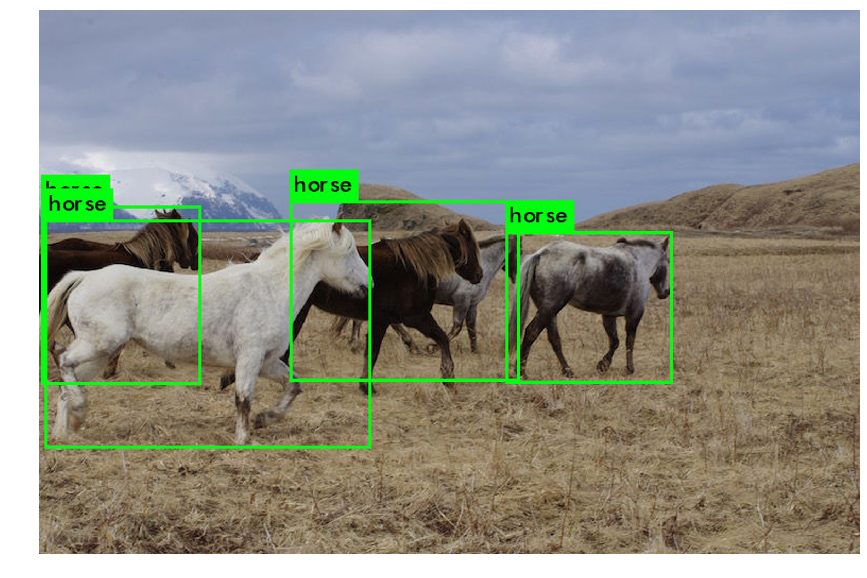

In [7]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect cfg/yolov3.cfg yolov3.weights data/horses.jpg -dont-show

# Show the result using the helper imgShow()
imShow('predictions.jpg')

## If you can see the same picture as the one below, congratulations!! At this point you have Darknet configured and working! 

![person.jpg](http://blog.ibanyez.info/download/B20190409T000000064.png)

# PART 2. Training YOLO

 > _**TRICK:** Every time you want to run all your cells automatically you can go to the **> Menu > Runtime > run all**. Maybe you don't want to execute the entire notebook. You can write the following cell where you want to stop the process and uncoment the **`assert False`** command. This will throw an error and will stop to run more cells. Thanks to: [This thread](https://groups.google.com/forum/#!topic/jupyter/ELftSFSiedQ)_




In [0]:
# don't go beyond here with Run All
#assert False

## PART 2. STEP 0. Preparing your data and configuration files 

Before going further let's take a look at what configuration files you need to have in your local drive _`darknet`_

![Yolov3 configuration files cheat sheet.jpg](http://blog.ibanyez.info/download/B20190410T000000072.png)

You can download the cheat sheet [here](http://blog.ibanyez.info/download/B20190410T000000072.png)

If you need deeper explanations on how to prepare your data sets, annotation and deep learning, visit [How to train YOLOv3 using Darknet framework and optimize the VM runtime load times](post link)


> **TRICK:** You have to be carefully configuring paths on your config files. _*obj.data*_ file needs to have spaces on the path escaped with _**\**_. Like this: **_/content/drive/My\ Drive/darknet/train.txt_**. But, in files **_train.txt_** and **_test.txt_** does not!




## PART 2. STEP 1. Loading files to VM local drive
The network speed between Google Drive and Colab VM can have an impact on your training speed accessing to your dataset images.

You can have 3 possible approaches depending on the size of your dataset. 

> _**NOTE:** This step is not necessary for all the configuration files and weights. They can be accessed directly from Google Drive without considerable performance issues. **This step is only for the dataset images and annotations**_

* **Option 1** - You can try  to use directly the files from Google Drive _`img/`_ folder. Depending on your dataset maybe this can be more than good.
* **Option 2** - Before start training copy your dataset from Google Drive to the local VM filesystem. Maybe can be a good practice to copy as one single tar file and decompress in your VM local _`img/`_ folder
* **Option 3** - If your dataset is quite big, maybe you can upload to a git repository and clone from here. Usually transfer time between are much better. If you have to decide I have the feeling that bitbucket have better speed transfer times than github, but please, don't take this as confirmed, **I haven't done specific tests on that, I could be wrong!** 




#### PART 2. STEP 1 - Option 1. Using files from Google Drive directly.
You don't have to do anything here. Your **_train.txt_** should have the correct path:
* **/content/grdive/My Drive/darknet/img/image001.jpg**. As said before, don't use escaped white space for the paths on _**train.txt**_ and _**test.txt**_

#### PART 2. STEP 1 - Option 2A. Copying files from Google Drive to VM local filesystem.
Execute the follow cell to copy your files

In [0]:
# Copy fils from Google Drive to the VM local filesystem
!cp -r "/content/drive/My Drive/darknet/img" ./img


In [0]:
!cp -r /content/drive/My\ Drive/darknet/img/* ./img

In [0]:
!cp -r /content/drive/My\ Drive/darknet/tmp/* ./

In [0]:
!cp -r /content/drive/My\ Drive/darknet/weights/ ./

In [0]:
!cp -r /content/drive/My\ Drive/darknet/cfg/* ./

#### PART 2. STEP 1 - Option 2B. Copying files zipped from Google Drive to VM local filesystem and unzip locally.
Execute the follow cell to copy your files and uncompress.
You can use _*!ls*_ command to esnure what's the correct path you have to configure in your _*train.txt*_ to correctly access to your dataset images


In [0]:
# Copy your compressed file
#!cp -r "/content/drive/My Drive/darknet/img/img.tgz" ./img

# Uncompress zipped file
#!tar -xzvf ./img/img.tgz

#### PART 2. STEP 1 - Option 3. Clone your image dataset from a git repo. Seems the fastest one.
Execute the follow cell to clone your dataset repo to VM local filesystem


In [0]:
# Git clone directly to ./img folder
#!git clone https://[your-repository] ./img

# Check the result - Uncomment when you checked for speed up further runs
#!ls -la ./img

## PART 3. Finally, Train your model!

When you execute the following command, your model will start training.

You will have a log line per epoch. On each iteration you will see how your training is going.

> **TRICK: Darknet copies a backup of your trained weights every 100 iterations. As magic, this file will be synced to your local drive on your computer, as well as the backups darknet do every 1000 iterations, saving it on a separate file.**





In [0]:
#!./darknet detector train "/content/drive/My Drive/darknet/obj.data" "/content/drive/My Drive/darknet/yolov3.cfg" "/content/drive/My Drive/darknet/darknet53.conv.74" -dont_show 

In [0]:
!./darknet detector train "/content/darknet/obj.data" "/content/darknet/yolov3.cfg" "/content/darknet/weights/darknet53.conv.74" 

layer     filters    size              input                output
   0 conv     32  3 x 3 / 1   416 x 416 x   3   ->   416 x 416 x  32 0.299 BF
   1 conv     64  3 x 3 / 2   416 x 416 x  32   ->   208 x 208 x  64 1.595 BF
   2 conv     32  1 x 1 / 1   208 x 208 x  64   ->   208 x 208 x  32 0.177 BF
   3 conv     64  3 x 3 / 1   208 x 208 x  32   ->   208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1
   5 conv    128  3 x 3 / 2   208 x 208 x  64   ->   104 x 104 x 128 1.595 BF
   6 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
   7 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5
   9 conv     64  1 x 1 / 1   104 x 104 x 128   ->   104 x 104 x  64 0.177 BF
  10 conv    128  3 x 3 / 1   104 x 104 x  64   ->   104 x 104 x 128 1.595 BF
  11 Shortcut Layer: 8
  12 conv    256  3 x 3 / 2   104 x 104 x 128   ->    52 x  52 x 256 1.595 BF
  13 conv    128  1 x 1 / 1    52 x  52 x 256   ->    52 x  52 x 128 0.177 BF
  14 c

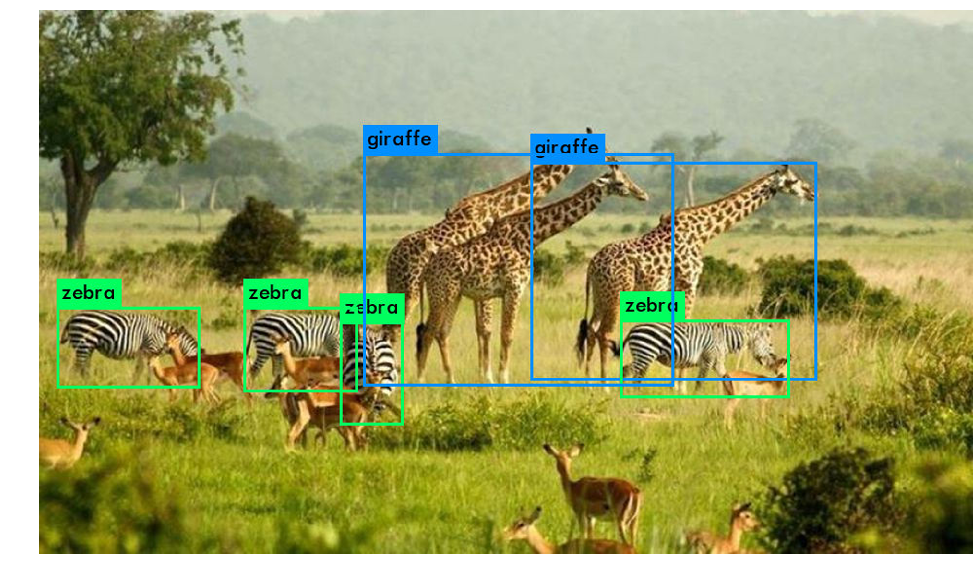

In [27]:
# Not necessary cell
# Execute darknet using YOLOv3 model with pre-trained weights to detect objects on 'person.jpg'
!./darknet detect cfg/yolov3.cfg yolov3.weights img/2019.jpg -dont-show


# Show the result using the helper imgShow()
imShow('predictions.jpg')

## PERFORMANCE TIPS & TRICKS

* **Speed up load times of the runtime:** When everything is checked that works, you can remove cells or comment unnecessary lines of code to make your loading time lower on every run. 

* **How to keep your notebook alive for more time?:** Keep you browser with your notebook open. If you close your browser, your notebook will reach the iddle time and will be removed from Colab cloud Service. (90 minutes)
  
* **Re-run your training after reaching the limitation time for Colab runtimes (12 hours):** 
  * Open a new notebook or reconnect the current one.
  * Comment the cell above and uncomment the cell below.
  * In your local computer, copy the file **backup/yolov3_last.weights** to your local computer **weights/** folder. 
  * Execute Run all in the **> menu > Runtime > Run All**
  * _The copy step is not absolutely necessary, but I like to keep a copy of the last training session and not overwrite this file on next trainings._

In [0]:
# Start training at the point where the last runtime finished
#!./darknet detector train "/content/drive/My Drive/darknet/obj.data" "/content/drive/My Drive/darknet/yolov3.cfg" "/content/drive/My Drive/darknet/weights/yolov_last.weights" -dont_show 

## TROUBLESHOOTING 
The main problems you can face if your model throw an error is:

* Images or files not found. Check the **Yolov3 cheat sheet** image above and check that everything is ok. 
* If have you configured wrongly your **filters** and **classes** in the **yolov3.cfg**. Check the **Yolov3 cheet sheet** above.
* You can face some out of memory or library errors mainly for the lack of some the pre-requisits. In this case, check the versions of the current libraries installed on your Colab VM. You can find more information in the first steps of this notebook.
* **Batch** and **subdivisions** parameters on your **yolov3.cfg** can affect to the memory allocation as well. Refer to the original repo [Here]() for further details.

### TROUBLESHOOTING UPDATE
Be careful if you are preparing your files on Windows. If you use **CRLF** on your files instead of **LF** You can have problems opening the files correctly. - Thanks to [Satya Shetty](https://twitter.com/satyashetty) for sharing this issue!


## About me

You can find the original post with more explanations about this notebook at [How to train YOLOv3 using Darknet framework and optimize the VM runtime load times](post link)

I'm David Ibañez from Barcelona. Feel free to get in touch!

* You can visit my blog at [Dev-ibanyez.info](http://blog.ibanyex.info)
* You can get in touch with me on [Twitter](https://twitter.com/dav_ibanez)
* You can get in touch or contribute to this notebook at [Github](https://github.com/kriyeng/yolo-on-colab-notebook/)
* You can comment on the [dev.to post about this notebook ](PENDING)

Thanks for you having read this notebook! :clap: :clap: :clap:

## SOURCES


#### Other sources
* YOLO original web site [Joseph Redmon Page](https://pjreddie.com/darknet/yolo/)
* AlexeyAB darknet repo [github](https://github.com/AlexeyAB/darknet/)
* The Ivan Goncharov [notebook](https://github.com/ivangrov/YOLOv3-GoogleColab/blob/master/YOLOv3_GoogleColab.ipynb) inspired me to try Google Colab and end up creating this notebook.